Pomysł 1:


predykcja -> segmentacja -> predykcja i porównanie


Pomysł 2:
*   Segmentacja 2 metody
*   predykcja 2 metody
*   polecanie 2 metody / przewidywanie zapotrzebowania - sprzedaży produktów

Feature engineering w oparciu o https://www.kaggle.com/tshephisho/ecommerce-behaviour-using-xgboost/notebook

In [1]:
# data manipulation and visualization
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

# model evalution and data preparation
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree

# models
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# settings
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('ticks')

In [15]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_clean.csv", index_col=0)

In [16]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26560620 entries, 0 to 26560619
Data columns (total 9 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   event_time     26560620 non-null  object 
 1   event_type     26560620 non-null  object 
 2   product_id     26560620 non-null  int64  
 3   category_id    26560620 non-null  int64  
 4   category_code  26560620 non-null  object 
 5   brand          26560620 non-null  object 
 6   price          26560620 non-null  float64
 7   user_id        26560620 non-null  int64  
 8   user_session   26560620 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.0+ GB


In [17]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
1,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
2,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
3,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
4,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880


In [18]:
# wybranie wierszy z danym event_type, usunięcie duplikatów z danych kolumn, tak aby w sesji jeden produkt został zakupiony tylko raz
df_final = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_final

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
111,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
197,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
268,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
339,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
343,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238
...,...,...,...,...,...,...,...,...,...
26560296,2019-10-31 23:55:21 UTC,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c
26560347,2019-10-31 23:56:03 UTC,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b
26560358,2019-10-31 23:56:11 UTC,cart,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b
26560403,2019-10-31 23:56:53 UTC,purchase,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b


In [19]:
# stworzenie labela czy dany produkt został zakupiony
df_final["is_purchased"] = np.where(df_final["event_type"]=="purchase",1,0)

In [20]:
# danie labela 1 lub 0 w zależności czy produkt po dodaniu do koszyka został zakupiony
df_final["is_purchased"] = df_final.groupby(["user_session","product_id"])["is_purchased"].transform("max")

In [21]:
# ponowne usunięcie duplikatów (zostawienie unikalnych produktów, które zostały dodane do koszyka i kupione), wybranie tylko wierszy z event_type cart
df_final = df_final.loc[df_final["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])

In [22]:
# przygotowanie kolumn z dniem tygodnia oraz godziną eventu
df_final['event_hour'] = pd.to_datetime(df_final['event_time']).dt.hour
df_final['event_weekday'] = df_final['event_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_final.dropna(how='any', inplace=True)

In [23]:
# stworzenie kolumn z kategoriami i podkategoriami
df_final["category_code_level1"] = df_final["category_code"].str.split(".",expand=True)[0]
df_final["category_code_level2"] = df_final["category_code"].str.split(".",expand=True)[1]

# kategorie trzeciego i czwartego poziomu
# df_xgb["has_category_code_level3"] = df_xgb["category_code"].str.split(".",expand=True)[2]
# df_xgb["has_category_code_level4"] = df_xgb["category_code"].str.split(".",expand=True)[3]
df_final.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_hour,event_weekday,category_code_level1,category_code_level2
343,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1,0,1,electronics,smartphone
398,2019-10-01 00:11:00 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,0,0,1,electronics,audio
810,2019-10-01 02:17:59 UTC,cart,1004833,2053013555631882655,electronics.smartphone,samsung,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,0,2,1,electronics,smartphone
1029,2019-10-01 02:19:36 UTC,cart,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,513632293,f2cc68f7-39d1-4a50-9dcf-f2a0921bdfda,1,2,1,electronics,smartphone
1047,2019-10-01 02:19:43 UTC,cart,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291,1,2,1,electronics,smartphone


In [24]:
# tylko część produktów posiada kody trzeciego i czwartego poziomu, więc zastąpimy je zerami
# df_xgb["has_category_code_level3"] = np.where(df_xgb["has_category_code_level3"].isnull(), 0, 1)
# df_xgb["has_category_code_level4"] = np.where(df_xgb["has_category_code_level4"].isnull(), 0, 1)

# df_xgb["has_category_code_level3"] = df_xgb['has_category_code_level3'].fillna(0)
# df_xgb["has_category_code_level4"] = df_xgb['has_category_code_level4'].fillna(0)
# df_xgb.head()

In [25]:
# Policzenie aktywności danego użytkownika w sesji
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]

activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

df_final = df_final.merge(activity_in_session, on='user_session', how='left')
df_final['activity_count'] = df_final['activity_count'].fillna(0)

Usunięcie zbędnych kolumn i ustawienie ich w odpowiedniej kolejności

In [26]:
df_final = df_final.drop(['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'user_id', 'user_session'], axis=1)
new_col_order = ["brand", "category_code_level1", "category_code_level2", "price", "event_weekday", "event_hour", "activity_count", "is_purchased"]
# new_col_order = ["brand", "category_code_level1", "category_code_level2", "has_category_code_level3", "has_category_code_level4", "price", "event_weekday", "event_hour", "activity_count", "is_purchased"]

df_final = df_final[new_col_order]
df_final.head()

,brand,category_code_level1,category_code_level2,price,event_weekday,event_hour,activity_count,is_purchased
0,apple,electronics,smartphone,515.67,1,0,4,1
1,apple,electronics,audio,161.98,1,0,4,0
2,samsung,electronics,smartphone,174.76,1,2,7,0
3,huawei,electronics,smartphone,258.21,1,2,16,1
4,samsung,electronics,smartphone,197.43,1,2,10,1


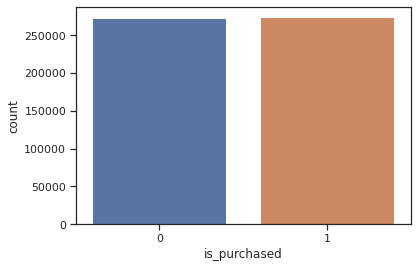

In [27]:
sns.countplot(x="is_purchased", data=df_final)

In [28]:
df_final.loc[:,'brand'] = LabelEncoder().fit_transform(df_final.loc[:,'brand'].copy())
df_final.loc[:,'event_weekday'] = LabelEncoder().fit_transform(df_final.loc[:,'event_weekday'].copy())
df_final.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(df_final.loc[:,'category_code_level1'].copy())
df_final.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(df_final.loc[:,'category_code_level2'].copy())
# df_final.loc[:,'has_category_code_level3'] = LabelEncoder().fit_transform(df_final.loc[:,'has_category_code_level3'].copy())
# df_final.loc[:,'has_category_code_level4'] = LabelEncoder().fit_transform(df_final.loc[:,'has_category_code_level4'].copy())

# df_final.insert(len(df_final.columns)-1, 'is_purchased', df_final.pop('is_purchased'))
df_final.head()

,brand,category_code_level1,category_code_level2,price,event_weekday,event_hour,activity_count,is_purchased
0,21,7,27,515.67,1,0,4,1
1,21,7,1,161.98,1,0,4,0
2,292,7,27,174.76,1,2,7,0
3,159,7,27,258.21,1,2,16,1
4,292,7,27,197.43,1,2,10,1


In [29]:
# przygotowanie zbiorów testowych i treningowych
features = df_final.iloc[:, :7]
is_purchased = df_final.iloc[:, 7]

# features = df_xgb.iloc[:, :10]
# is_purchased = df_xgb.iloc[:, 10]

X_train, X_test, Y_train, Y_test = train_test_split(features, 
                                                    is_purchased, 
                                                    test_size = 0.3, 
                                                    random_state = 20)

Y_train.value_counts()

1    191773
0    190847
Name: is_purchased, dtype: int64

zbiór danych nie wymaga balansowania

### Logistic regression

In [34]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, Y_train)
log_pred = log_reg.predict(X_test)
print(log_pred)

[0 1 0 ... 0 1 0]


In [35]:
print("Accuracy:", metrics.accuracy_score(Y_test, log_pred))
print("Precision:",metrics.precision_score(Y_test, log_pred))
print("Recall:",metrics.recall_score(Y_test, log_pred))
print("fbeta:",metrics.fbeta_score(Y_test, log_pred, average='weighted', beta=0.5))

Accuracy: 0.5395475057933894
Precision: 0.5338492480780814
Recall: 0.6366270575630661
fbeta: 0.537332765448643


### XGBoost

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, Y_train)
Y_pred = model_xgb.predict(X_test)

In [ ]:
print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred))
print("Precision:", metrics.precision_score(Y_test, Y_pred))
print("Recall:", metrics.recall_score(Y_test, Y_pred))
print("fbeta:", metrics.fbeta_score(Y_test, Y_pred, average='weighted', beta=0.5))

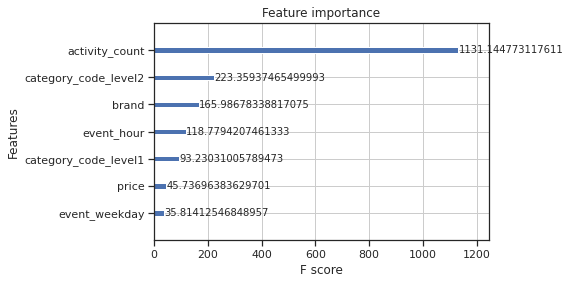

In [32]:
plot_importance(model_xgb, max_num_features=12, importance_type ='gain')
plt.show()

### LightGBM

In [33]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, Y_train)
Y_pred_lgbm = lgbm.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_lgbm))
print("Precision:", metrics.precision_score(Y_test, Y_pred_lgbm))
print("Recall:", metrics.recall_score(Y_test, Y_pred_lgbm))
print("fbeta:", metrics.fbeta_score(Y_test, Y_pred_lgbm, average='weighted', beta=0.5))
print(f"F1 Score: {f1_score(Y_test, Y_pred_lgbm, average='macro')}")

Accuracy: 0.6134650567142335
Precision: 0.5968815226601087
Recall: 0.7032847959481835
fbeta: 0.6131241517065239
F1 Score: 0.6102322748265001


### Decision tree

In [36]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
Y_dtc_pred = dtc.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_dtc_pred))
print("Precision:", metrics.precision_score(Y_test, Y_dtc_pred))
print("Recall:", metrics.recall_score(Y_test, Y_dtc_pred))
print("fbeta:", metrics.fbeta_score(Y_test, Y_dtc_pred, average='weighted', beta=0.5))

Accuracy: 0.5558543724844494
Precision: 0.5589080641689563
Recall: 0.537425732930749
fbeta: 0.5558130898555167


### Random forest

In [37]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_rfc_pred = rfc.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_rfc_pred))
print("Precision:", metrics.precision_score(Y_test, Y_rfc_pred))
print("Recall:", metrics.recall_score(Y_test, Y_rfc_pred))
print("fbeta:", metrics.fbeta_score(Y_test, Y_rfc_pred, average='weighted', beta=0.5))

Accuracy: 0.5767776558116844
Precision: 0.5771112348938026
Recall: 0.5802449595792344
fbeta: 0.5767734628047851


### Naive Bayes

In [38]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_gnb_pred = gnb.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_gnb_pred))
print("Precision:", metrics.precision_score(Y_test, Y_gnb_pred))
print("Recall:", metrics.recall_score(Y_test, Y_gnb_pred))
print("fbeta:", metrics.fbeta_score(Y_test, Y_gnb_pred, average='weighted', beta=0.5))

Accuracy: 0.5424868886449568
Precision: 0.5301753760786011
Recall: 0.7607748125060875
fbeta: 0.5307342961592212
